**Author**: Andy Tzanidakis \
Last updated: May 05, 2024

## Overview



### VizieR Query


### Crossmatch to ZTF

### Compute Time-Series Featues with `TAPE`

### Exercise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['axes.linewidth'] = 2

import lsdb
import tape
from tape import Ensemble, ColumnMapper

import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

from dask.distributed import Client

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


## VizieR Querying

In [2]:
## ViZier and Aladin querying 
from pyvo import registry  # version >=1.4.1 
from mocpy import MOC
from ipyaladin import Aladin

In [3]:
# the catalogue name in VizieR (Gaia DR3 part 6)
CATALOGUE = "I/360"

catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"

# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()

# We can also extract the tables names for later use
tables_names = list(tables.keys())

In [4]:
print (f"Available table names: {tables_names}")

Available table names: ['I/360/syntphot', 'I/360/goldu', 'I/360/goldsp', 'I/360/goldsa', 'I/360/goldoba', 'I/360/goldf', 'I/360/goldc', 'I/360/binmass']


In [5]:
# Let's read quickly the table description...
voresource.describe(verbose=True)

Gaia DR3 Part 6. Performance verification
Short Name: I/360
IVOA Identifier: ivo://cds.vizier/i/360
Access modes: conesearch, hips#hips-1.0, tap#aux, web
Multi-capabilty service -- use get_service()

Gaia Data Release 3 (Gaia DR3) will be released on 13 June 2022. The Gaia DR3
catalogue builds upon the Early Data Release 3 (released on 3 December 2020)
and combines, for the same stretch of time and the same set of observations,
these already-published data products with numerous new data products such as
extended objects and non-single stars.

Subjects: I/360
Waveband Coverage: optical
More info: https://cdsarc.cds.unistra.fr/viz-bin/cat/I/360


In [6]:
# Select the first table name
table_name_1 = "I/360/goldf"
first_table_name = table_name_1

In [7]:
tap_service = voresource.get_service("tap")
tap_records = voresource.get_service("tap").run_sync(f'SELECT TOP 2000000  * \
                            FROM "{first_table_name}" WHERE (DE_ICRS > -30)')

In [8]:
table0 = tap_records.to_table()

# Convert to pandas dataframe
table_df = table0.to_pandas()

In [9]:
# select only M-type stars
table_df = table_df[table_df['SpType'].str.contains('M')]

In [10]:
table_df.head(1)

,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,...,Rad-FS,Lum-FS,Mass-FS,Age-FS,evol-FS,SpType,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs
188,1015607,2906146503664238592,3699.9863,4.7953,-0.2256,0.3829,0.2239,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,<NA>,M,80.970933,-29.992279,80.970933,-29.992279


In [11]:
client = Client(n_workers=6, threads_per_worker=1, memory_limit='auto')

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40741 instead
  warnings.warn(


In [12]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40741/status,
Dashboard: http://127.0.0.1:40741/status,Workers: 6
Total threads: 6,Total memory: 62.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44090,Workers: 6
Dashboard: http://127.0.0.1:40741/status,Total threads: 6
Started: Just now,Total memory: 62.97 GiB
Comm: tcp://127.0.0.1:42315,Total threads: 1
Dashboard: http://127.0.0.1:36421/status,Memory: 10.50 GiB
Nanny: tcp://127.0.0.1:45031,


In [13]:
%%time
hips_object = lsdb.from_dataframe(
    table_df,
    catalog_name="golden",
    catalog_type="object",
    ra_column="RA_ICRS", 
    dec_column="DE_ICRS")

CPU times: user 1min 9s, sys: 7.12 s, total: 1min 16s
Wall time: 1min 9s


In [14]:
hips_object

,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,[M/H]-S,Rad-F,Lum-F,Mass-F,Age-F,evol-F,Rad-FS,Lum-FS,Mass-FS,Age-FS,evol-FS,SpType,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs,Norder,Dir,Npix
npartitions=12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,Int16,float64,float64,float64,float64,Int16,string,float64,float64,float64,float64,uint8,uint64,uint64
1152921504606846976,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12682136550675316736,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
%%time
hips_object.head(1)

CPU times: user 45 ms, sys: 14.3 ms, total: 59.4 ms
Wall time: 131 ms


,recno,Source,Teff-P,logg-P,[M/H]-P,AG-P,E(BP-RP)-P,[alphe/Fe]-S,Teff-S,logg-S,...,Age-FS,evol-FS,SpType,RA_ICRS,DE_ICRS,_RA_icrs,_DE_icrs,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
197754504609792,3267192,98857263018112,3542.0205,4.8119,-0.6898,0.4936,0.2947,NaN,NaN,NaN,...,NaN,<NA>,M,44.655283,0.729574,44.655283,0.729574,0,0,0


## Load Additional Catalogs

In [16]:
# load ZTF source table
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_zource")

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14",
                        columns=['ps1_objid', 'nobs_r', 'nobs_g', 'ra', 'dec']) # select only Nobs (gr) bands

In [17]:
ztf

,ps1_objid,nobs_r,nobs_g,ra,dec
npartitions=2352,,,,,
0,int64,int32,int32,float64,float64
18014398509481984,...,...,...,...,...
...,...,...,...,...,...
13830554455654793216,...,...,...,...,...
18446744073709551615,...,...,...,...,...


## Crossmatch

In [18]:
xmatch_golden_ztf_object = hips_object.crossmatch(ztf, n_neighbors=1, radius_arcsec=1, require_right_margin=False)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


In [19]:
xmatch_golden_ztf_object.head(1)

,recno_golden,Source_golden,Teff-P_golden,logg-P_golden,[M/H]-P_golden,AG-P_golden,E(BP-RP)-P_golden,[alphe/Fe]-S_golden,Teff-S_golden,logg-S_golden,...,_DE_icrs_golden,Norder_golden,Dir_golden,Npix_golden,ps1_objid_ztf_dr14,nobs_r_ztf_dr14,nobs_g_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
197754504609792,3267192,98857263018112,3542.0205,4.8119,-0.6898,0.4936,0.2947,NaN,NaN,NaN,...,0.729574,0,0,0,108870446552145874,386,373,44.655283,0.729621,0.16896


In [20]:
%%time
# Head of xmatch table with 250k rows for exploration
xmatch_golden_ztf_object_comp = xmatch_golden_ztf_object.compute()

CPU times: user 2min 30s, sys: 20.4 s, total: 2min 50s
Wall time: 5min 42s


In [21]:
%%time
hips_object_v2 = lsdb.from_dataframe(
    xmatch_golden_ztf_object_comp,
    catalog_name="golden",
    catalog_type="object",
    ra_column="ra_ztf_dr14", 
    dec_column="dec_ztf_dr14")

CPU times: user 1min, sys: 6.45 s, total: 1min 6s
Wall time: 1min


In [ ]:
xmatch_golden_ztf_object_comp.keys()

Text(0, 0.5, '$\\log_{10} L/L_\\odot$')

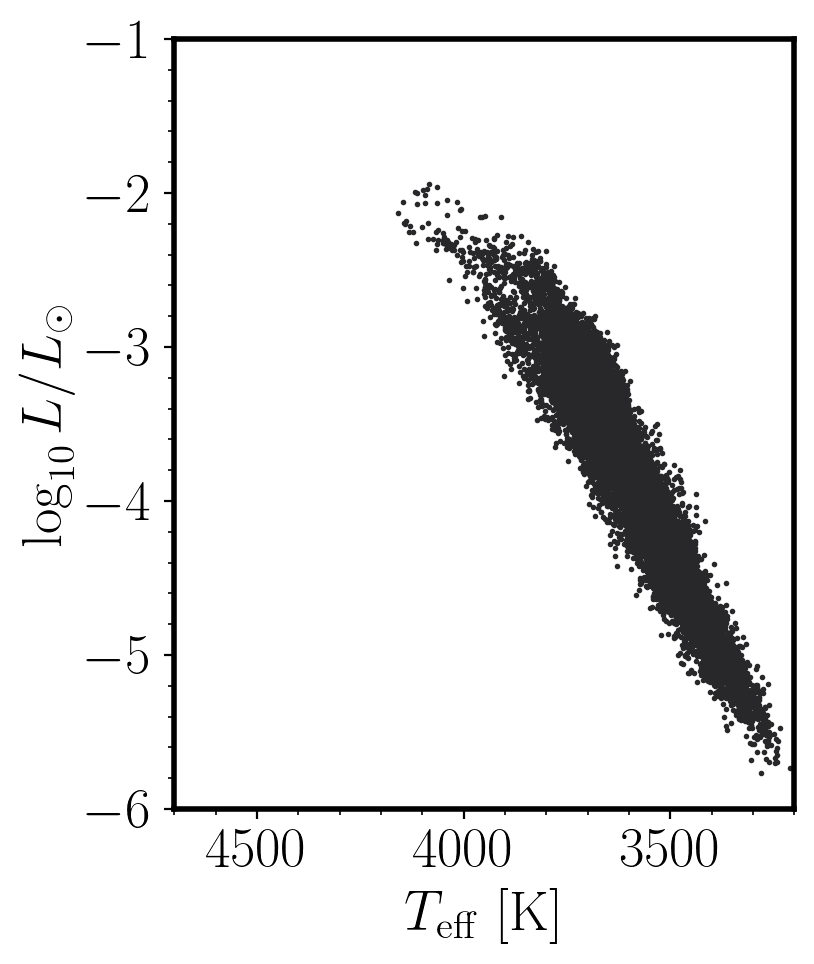

In [22]:
plt.figure(figsize=(4, 5))
plt.scatter(xmatch_golden_ztf_object_comp['Teff-P_golden'],
             np.log(xmatch_golden_ztf_object_comp['Lum-F_golden']), s=1, 
             color='#28282B')
plt.xlim(plt.xlim(3200, 4700)[::-1])
plt.ylim(-6, -1)
plt.minorticks_on()
plt.xlabel(r"$T_{\rm eff}$ [K]")
plt.ylabel(r"$\log_{10} L/L_\odot$")


In [52]:
%%time
# sync source catalog data to object (xmatched) object
_sources = hips_object_v2.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/lsdb/dask/join_catalog_data.py:195: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 16.9 s, sys: 1.4 s, total: 18.3 s
Wall time: 17.2 s


## TAPE

In [53]:
# Initialize an Ensemble
ens = Ensemble(client=client)
ens.client_info()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40741/status,
Dashboard: http://127.0.0.1:40741/status,Workers: 6
Total threads: 6,Total memory: 62.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44090,Workers: 6
Dashboard: http://127.0.0.1:40741/status,Total threads: 6
Started: 30 minutes ago,Total memory: 62.97 GiB
Comm: tcp://127.0.0.1:43699,Total threads: 1
Dashboard: http://127.0.0.1:36426/status,Memory: 10.50 GiB
Nanny: tcp://127.0.0.1:45031,


In [54]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=hips_object_v2._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

## Calculating Time-Series Features

In [ ]:
!pip install cesium

In [55]:
from cesium import featurize

In [56]:
features_to_use = ['amplitude',
                'percent_beyond_1_std',
                'maximum',
                'median',
                'median_absolute_deviation',
                'percent_close_to_median',
                'minimum',
                'skew',
                'std',
                'weighted_average', 
                "flux_percentile_ratio_mid20", 
                "flux_percentile_ratio_mid35",
                "flux_percentile_ratio_mid50",
                "flux_percentile_ratio_mid65",
                "flux_percentile_ratio_mid80",
                "stetson_j",
                  "stetson_k"]

In [57]:
def compute_features(time, mag, magerr, flag, band, custom_cols=features_to_use):
    
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    # Removed flagged data points
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]

    # Compute features
    summary_ = {}

    if len(time_) > 0: 
        fset_cesium = featurize.featurize_time_series(
        times=time_,
        values=mag_,
        errors=magerr_,
        features_to_use=custom_cols)
    else:
        fset_cesium = pd.Series(list(np.zeros(len(features_to_use))), index=custom_cols) 
    
    return pd.Series(fset_cesium.values[0], index=custom_cols) 



In [58]:
# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=features_to_use, dtype=float)

In [59]:
_sources

,recno_golden_golden,Source_golden_golden,Teff-P_golden_golden,logg-P_golden_golden,[M/H]-P_golden_golden,AG-P_golden_golden,E(BP-RP)-P_golden_golden,[alphe/Fe]-S_golden_golden,Teff-S_golden_golden,logg-S_golden_golden,[M/H]-S_golden_golden,Rad-F_golden_golden,Lum-F_golden_golden,Mass-F_golden_golden,Age-F_golden_golden,evol-F_golden_golden,Rad-FS_golden_golden,Lum-FS_golden_golden,Mass-FS_golden_golden,Age-FS_golden_golden,evol-FS_golden_golden,SpType_golden_golden,RA_ICRS_golden_golden,DE_ICRS_golden_golden,_RA_icrs_golden_golden,_DE_icrs_golden_golden,Norder_golden_golden,Dir_golden_golden,Npix_golden_golden,ps1_objid_ztf_dr14_golden,nobs_r_ztf_dr14_golden,nobs_g_ztf_dr14_golden,ra_ztf_dr14_golden,dec_ztf_dr14_golden,_dist_arcsec_golden,Norder_golden,Dir_golden,Npix_golden,index_ztf_zource,ps1_objid_ztf_zource,ra_ztf_zource,dec_ztf_zource,ps1_gMeanPSFMag_ztf_zource,ps1_rMeanPSFMag_ztf_zource,ps1_iMeanPSFMag_ztf_zource,nobs_g_ztf_zource,nobs_r_ztf_zource,nobs_i_ztf_zource,mean_mag_g_ztf_zource,mean_mag_r_ztf_zource,mean_mag_i_ztf_zource,catflags_ztf_zource,fieldID_ztf_zource,mag_ztf_zource,magerr_ztf_zource,mjd_ztf_zource,rcID_ztf_zource,band_ztf_zource,Norder_ztf_zource,Dir_ztf_zource,Npix_ztf_zource
npartitions=41679,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,int64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,Int16,float64,float64,float64,float64,Int16,string,float64,float64,float64,float64,uint8,uint64,uint64,int64,int32,int32,float64,float64,float64,uint8,uint64,uint64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,uint8,uint64,uint64
4503599627370496,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833932155375321088,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [60]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    compute_features,
    'mjd_ztf_zource', 'mag_ztf_zource', 
    'magerr_ztf_zource', 'catflags_ztf_zource',
    'band_ztf_zource',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 64.6 ms, sys: 9.07 ms, total: 73.7 ms
Wall time: 70 ms


In [44]:
%%time
#ens.object.join(calc_).update_ensemble()

CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 29.1 µs


In [45]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40741/status,
Dashboard: http://127.0.0.1:40741/status,Workers: 6
Total threads: 6,Total memory: 62.97 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44090,Workers: 6
Dashboard: http://127.0.0.1:40741/status,Total threads: 6
Started: 26 minutes ago,Total memory: 62.97 GiB
Comm: tcp://127.0.0.1:43699,Total threads: 1
Dashboard: http://127.0.0.1:36426/status,Memory: 10.50 GiB
Nanny: tcp://127.0.0.1:45031,


In [61]:
dask.config.set({"dataframe.convert-string": False})

In [62]:
%%time
obj_features = calc_.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 26.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-05-05 22:30:57,545 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-05-05 22:30:57,899 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-05-05 22:30:58,439 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-05-05 22:31:00,504 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 7.47 GiB -- Worker memory limit: 1